##### Import libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.multitest as sm
import statsmodels.stats.proportion as smp
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC


# 1. Data Preprocessing

##### Load Dataset

In [107]:
data = pd.ExcelFile("/Users/yawdapaa/Customer_Churn_Data_Large.xlsx")

##### Preview each sheet in the Excel file

In [108]:
# Load and preview each sheet to understand its contents
demo_df = data.parse('Customer_Demographics')
trans_df = data.parse('Transaction_History')
service_df = data.parse('Customer_Service')
online_df = data.parse('Online_Activity')
churn_df = data.parse('Churn_Status')

# Preview the first few rows of each dataset
{
    "Customer_Demographics": demo_df.head(),
    "Transaction_History": trans_df.head(),
    "Customer_Service": service_df.head(),
    "Online_Activity": online_df.head(),
    "Churn_Status": churn_df.head()
}

{'Customer_Demographics':    CustomerID  Age Gender MaritalStatus IncomeLevel
 0           1   62      M        Single         Low
 1           2   65      M       Married         Low
 2           3   18      M        Single         Low
 3           4   21      M       Widowed         Low
 4           5   21      M      Divorced      Medium,
 'Transaction_History':    CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
 0           1           7194      2022-03-27       416.50     Electronics
 1           2           7250      2022-08-08        54.96        Clothing
 2           2           9660      2022-07-25       197.50     Electronics
 3           2           2998      2022-01-25       101.31       Furniture
 4           2           1228      2022-07-24       397.37        Clothing,
 'Customer_Service':    CustomerID  InteractionID InteractionDate InteractionType ResolutionStatus
 0           1           6363      2022-03-31         Inquiry         Resolved
 1  

##### Shape of Data in each sheet

In [109]:
# shape of each dataset
{
    "Customer_Demographics": demo_df.shape,
    "Transaction_History": trans_df.shape,
    "Customer_Service": service_df.shape,
    "Online_Activity": online_df.shape,
    "Churn_Status": churn_df.shape
}

{'Customer_Demographics': (1000, 5),
 'Transaction_History': (5054, 5),
 'Customer_Service': (1002, 5),
 'Online_Activity': (1000, 4),
 'Churn_Status': (1000, 2)}

##### Summarize each dataset by CustomerID to prepare for merging
###### Since Customer_Demographics is the main table and has the since number of rows as Online_Activity and Churn_Status, we will summarize the other two datasets(Transaction_History & Customer_Service) by CustomerID to prepare for merging.

In [110]:
# Summarize transaction history
trans_summary = trans_df.groupby("CustomerID").agg({
    "AmountSpent": ["sum", "mean", "count"],
    "TransactionDate": "max"
}).reset_index()
trans_summary.columns = ["CustomerID", "TotalSpent", "AvgSpent", "TransactionCount", "LastTransactionDate"]

In [111]:
# Summarize customer service interactions
service_summary = service_df.groupby("CustomerID").agg({
    "InteractionID": "count",
    "InteractionType": lambda x: (x == "Complaint").sum(),
    "ResolutionStatus": lambda x: (x == "Unresolved").sum()
}).reset_index()
service_summary.columns = ["CustomerID", "ServiceInteractions", "InteractionType", "UnresolvedIssues"]

##### Merge the sheets into a single DataFrame

In [112]:
# Merge all datasets on CustomerID
merged_df = demo_df.merge(trans_summary, on="CustomerID", how="left") \
                   .merge(service_summary, on="CustomerID", how="left") \
                   .merge(online_df, on="CustomerID", how="left") \
                   .merge(churn_df, on="CustomerID", how="left")

# Preview merged data
merged_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,TransactionCount,LastTransactionDate,ServiceInteractions,InteractionType,UnresolvedIssues,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,416.50,416.50000,1,2022-03-27,1.0,0.0,0.0,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,1547.42,221.06000,7,2022-11-19,1.0,0.0,0.0,2023-12-05,5,Website,1
2,3,18,M,Single,Low,1702.98,283.83000,6,2022-10-08,1.0,0.0,0.0,2023-11-15,3,Website,0
3,4,21,M,Widowed,Low,917.29,183.45800,5,2022-12-27,2.0,0.0,1.0,2023-08-25,2,Website,0
4,5,21,M,Divorced,Medium,2001.49,250.18625,8,2022-12-21,NaN,NaN,NaN,2023-10-27,41,Website,0


##### Save the merged data to a new Excel file for future use

In [113]:
merged_df.to_excel("/Users/yawdapaa/Merged_Customer_Churn_Data.xlsx", index=False)

# 2. Data Cleaning

In [114]:
# Preview merged data
merged_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,TransactionCount,LastTransactionDate,ServiceInteractions,InteractionType,UnresolvedIssues,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,416.50,416.50000,1,2022-03-27,1.0,0.0,0.0,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,1547.42,221.06000,7,2022-11-19,1.0,0.0,0.0,2023-12-05,5,Website,1
2,3,18,M,Single,Low,1702.98,283.83000,6,2022-10-08,1.0,0.0,0.0,2023-11-15,3,Website,0
3,4,21,M,Widowed,Low,917.29,183.45800,5,2022-12-27,2.0,0.0,1.0,2023-08-25,2,Website,0
4,5,21,M,Divorced,Medium,2001.49,250.18625,8,2022-12-21,NaN,NaN,NaN,2023-10-27,41,Website,0


In [115]:
merged_df.shape

(1000, 16)

In [116]:
# Summary of merged data
merged_df.describe(include='all')

/var/folders/b2/7lb8lsn518n1jwswggqzrft00000gn/T/ipykernel_73702/2246092885.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged_df.describe(include='all')
/var/folders/b2/7lb8lsn518n1jwswggqzrft00000gn/T/ipykernel_73702/2246092885.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged_df.describe(include='all')


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,TransactionCount,LastTransactionDate,ServiceInteractions,InteractionType,UnresolvedIssues,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
count,1000.000000,1000.000000,1000,1000,1000,1000.000000,1000.000000,1000.000000,1000,668.000000,668.000000,668.000000,1000,1000.000000,1000,1000.000000
unique,NaN,NaN,2,4,3,NaN,NaN,NaN,254,NaN,NaN,NaN,340,NaN,3,NaN
top,NaN,NaN,F,Widowed,High,NaN,NaN,NaN,2022-12-15 00:00:00,NaN,NaN,NaN,2023-09-20 00:00:00,NaN,Online Banking,NaN
freq,NaN,NaN,513,276,349,NaN,NaN,NaN,18,NaN,NaN,NaN,8,NaN,349,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-10 00:00:00,NaN,NaN,NaN,2023-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31 00:00:00,NaN,NaN,NaN,2023-12-31 00:00:00,NaN,NaN,NaN
mean,500.500000,43.267000,NaN,NaN,NaN,1267.074950,248.806511,5.054000,NaN,1.500000,0.501497,0.717066,NaN,25.912000,NaN,0.204000
std,288.819436,15.242311,NaN,NaN,NaN,738.590013,79.372766,2.603433,NaN,0.500375,0.603586,0.638032,NaN,14.055953,NaN,0.403171
min,1.000000,18.000000,NaN,NaN,NaN,9.800000,9.800000,1.000000,NaN,1.000000,0.000000,0.000000,NaN,1.000000,NaN,0.000000
25%,250.750000,30.000000,NaN,NaN,NaN,626.685000,203.734167,3.000000,NaN,1.000000,0.000000,0.000000,NaN,13.750000,NaN,0.000000


In [117]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           1000 non-null   int64         
 1   Age                  1000 non-null   int64         
 2   Gender               1000 non-null   object        
 3   MaritalStatus        1000 non-null   object        
 4   IncomeLevel          1000 non-null   object        
 5   TotalSpent           1000 non-null   float64       
 6   AvgSpent             1000 non-null   float64       
 7   TransactionCount     1000 non-null   int64         
 8   LastTransactionDate  1000 non-null   datetime64[ns]
 9   ServiceInteractions  668 non-null    float64       
 10  InteractionType      668 non-null    float64       
 11  UnresolvedIssues     668 non-null    float64       
 12  LastLoginDate        1000 non-null   datetime64[ns]
 13  LoginFrequency       1000 non-null

In [118]:
# Checking for columns with missing values
missing_values = merged_df.isnull().sum()
print(missing_values)

CustomerID               0
Age                      0
Gender                   0
MaritalStatus            0
IncomeLevel              0
TotalSpent               0
AvgSpent                 0
TransactionCount         0
LastTransactionDate      0
ServiceInteractions    332
InteractionType        332
UnresolvedIssues       332
LastLoginDate            0
LoginFrequency           0
ServiceUsage             0
ChurnStatus              0
dtype: int64


##### Handle missing values

In [119]:
# Drop columns with more than 50% missing values
missing_values_percentage = merged_df.isnull().mean() * 100
columns_to_drop = missing_values_percentage[missing_values_percentage > 50].index
merged_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values for categorical variables with mode. There were no missing values for categorical variables.
categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

# Fill missing values for numerical variables with median. Using the median is robust to outliers and prevents significant skewing of the data distribution.
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    merged_df[col].fillna(merged_df[col].median(), inplace=True)

In [120]:
merged_df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
MaritalStatus          0
IncomeLevel            0
TotalSpent             0
AvgSpent               0
TransactionCount       0
LastTransactionDate    0
ServiceInteractions    0
InteractionType        0
UnresolvedIssues       0
LastLoginDate          0
LoginFrequency         0
ServiceUsage           0
ChurnStatus            0
dtype: int64

##### Drop the columns not needed for analysis

In [121]:
merged_df.drop(columns=["CustomerID", "LastTransactionDate", "LastLoginDate"], inplace=True)

In [122]:
# Counting frequency of entries for all variables using a for loop
for cols in merged_df.columns:
    print(merged_df[cols].value_counts())

21    30
23    26
54    26
18    24
53    24
68    24
69    23
25    22
48    22
37    22
41    22
38    22
30    22
45    21
64    21
63    21
27    21
36    20
61    20
47    20
42    20
59    20
24    20
34    20
52    19
51    19
56    19
28    19
66    19
44    19
46    19
58    18
33    18
67    18
26    18
50    18
43    18
57    17
19    17
55    17
35    17
31    16
20    16
22    16
29    15
39    15
62    14
60    14
65    14
40    13
32    13
49    12
Name: Age, dtype: int64
F    513
M    487
Name: Gender, dtype: int64
Widowed     276
Married     261
Divorced    248
Single      215
Name: MaritalStatus, dtype: int64
High      349
Medium    326
Low       325
Name: IncomeLevel, dtype: int64
1108.56    2
1099.45    2
13.04      2
416.50     1
77.31      1
          ..
1022.86    1
2295.76    1
924.63     1
1466.60    1
1670.79    1
Name: TotalSpent, Length: 997, dtype: int64
224.067500    2
13.040000     2
416.500000    1
77.310000     1
334.532500    1
             ..
191.1800

In [123]:
# printing the unique values in all the categorical columns
numerical_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()

for col in merged_df.columns:
    if col not in numerical_cols:
        print(f"Unique values in {col}:")
        print(merged_df[col].unique())
        print("-"*50)

Unique values in Gender:
['M' 'F']
--------------------------------------------------
Unique values in MaritalStatus:
['Single' 'Married' 'Widowed' 'Divorced']
--------------------------------------------------
Unique values in IncomeLevel:
['Low' 'Medium' 'High']
--------------------------------------------------
Unique values in ServiceUsage:
['Mobile App' 'Website' 'Online Banking']
--------------------------------------------------


##### Summary Statistics of the Cleaned Data

In [124]:
# Summary statistics for numerical columns
numerical_summary = merged_df[numerical_cols].describe()
print(numerical_summary)

               Age   TotalSpent     AvgSpent  TransactionCount  \
count  1000.000000  1000.000000  1000.000000       1000.000000   
mean     43.267000  1267.074950   248.806511          5.054000   
std      15.242311   738.590013    79.372766          2.603433   
min      18.000000     9.800000     9.800000          1.000000   
25%      30.000000   626.685000   203.734167          3.000000   
50%      43.000000  1232.880000   250.121458          5.000000   
75%      56.000000  1791.902500   295.023854          7.000000   
max      69.000000  3386.040000   496.990000          9.000000   

       ServiceInteractions  InteractionType  UnresolvedIssues  LoginFrequency  \
count          1000.000000      1000.000000       1000.000000     1000.000000   
mean              1.500000         0.335000          0.811000       25.912000   
std               0.408861         0.546877          0.538116       14.055953   
min               1.000000         0.000000          0.000000        1.000000   


# 3. Exploratory Data Analysis (EDA)

##### Visualize distributions of key categorical variables and churn

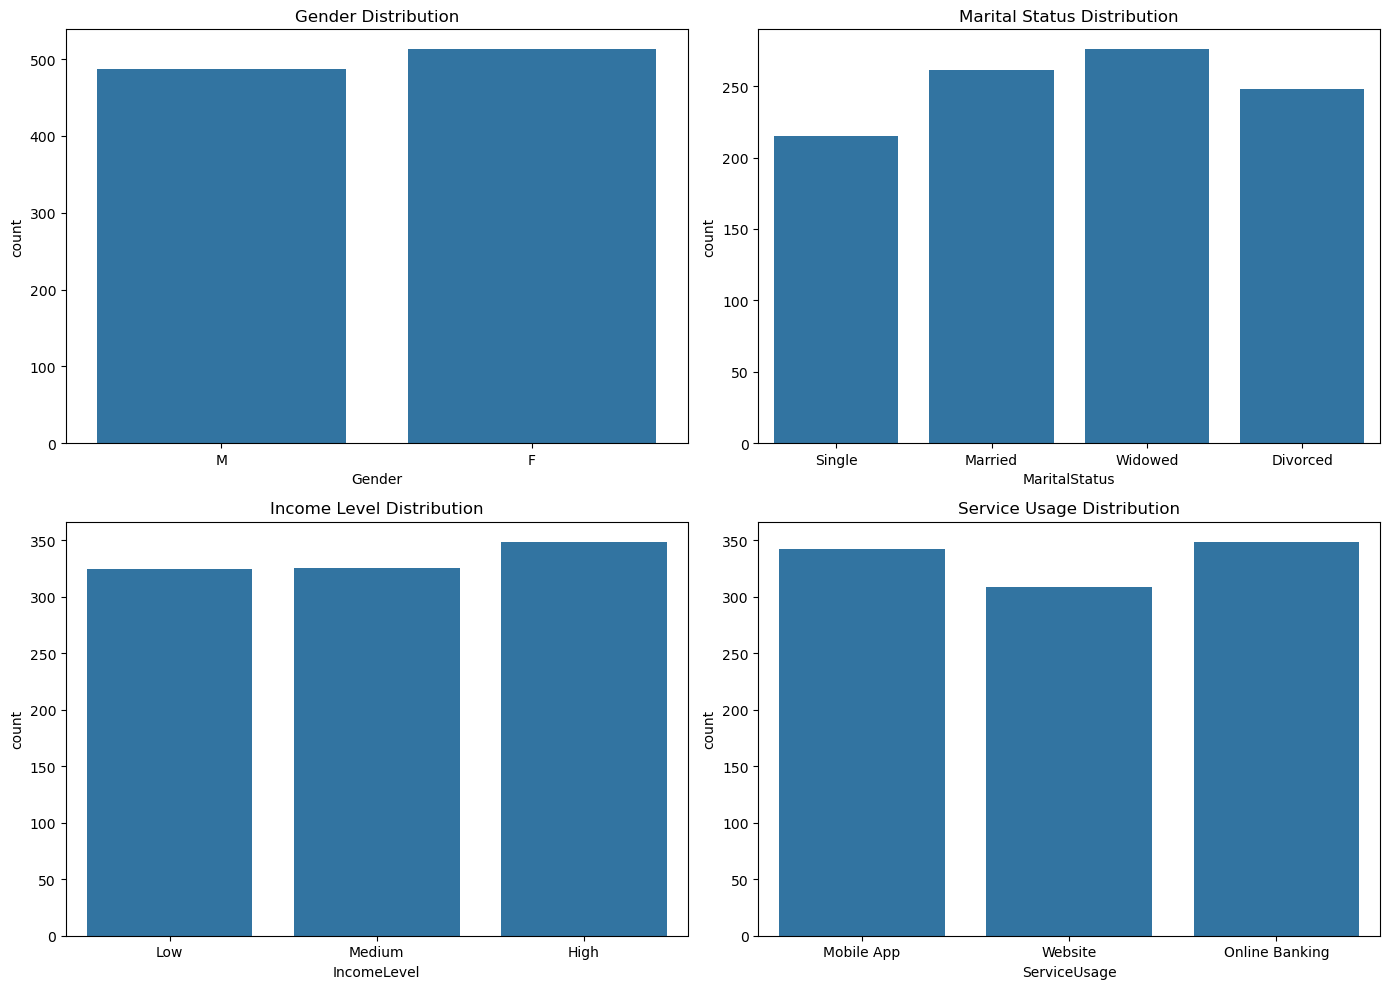

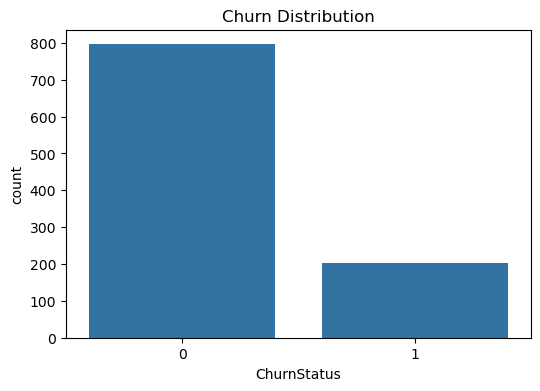

In [125]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.countplot(x='Gender', data=merged_df, ax=axes[0,0])
axes[0,0].set_title('Gender Distribution')
sns.countplot(x='MaritalStatus', data=merged_df, ax=axes[0,1])
axes[0,1].set_title('Marital Status Distribution')
sns.countplot(x='IncomeLevel', data=merged_df, ax=axes[1,0])
axes[1,0].set_title('Income Level Distribution')
sns.countplot(x='ServiceUsage', data=merged_df, ax=axes[1,1])
axes[1,1].set_title('Service Usage Distribution')
plt.tight_layout()
plt.show()

# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='ChurnStatus', data=merged_df)
plt.title('Churn Distribution')
plt.show()

### The charts above show:

#### Gender is nearly balanced.
#### Marital status is fairly distributed, with 'Widowed' being the most common.
#### Income levels are well spread across 'High', 'Medium', and 'Low'.
#### Service usage is split among 'Online Banking', 'Mobile App', and 'Website'.

In [126]:
print("Churn distribution:")
print(merged_df['ChurnStatus'].value_counts())
print(f"Churn rate: {merged_df['ChurnStatus'].mean():.2%}")

Churn distribution:
0    796
1    204
Name: ChurnStatus, dtype: int64
Churn rate: 20.40%


#### The churn distribution plot confirms that about 20% of customers have churned.

## Next, let's explore the distributions of key numerical variables and their relationships with churn.

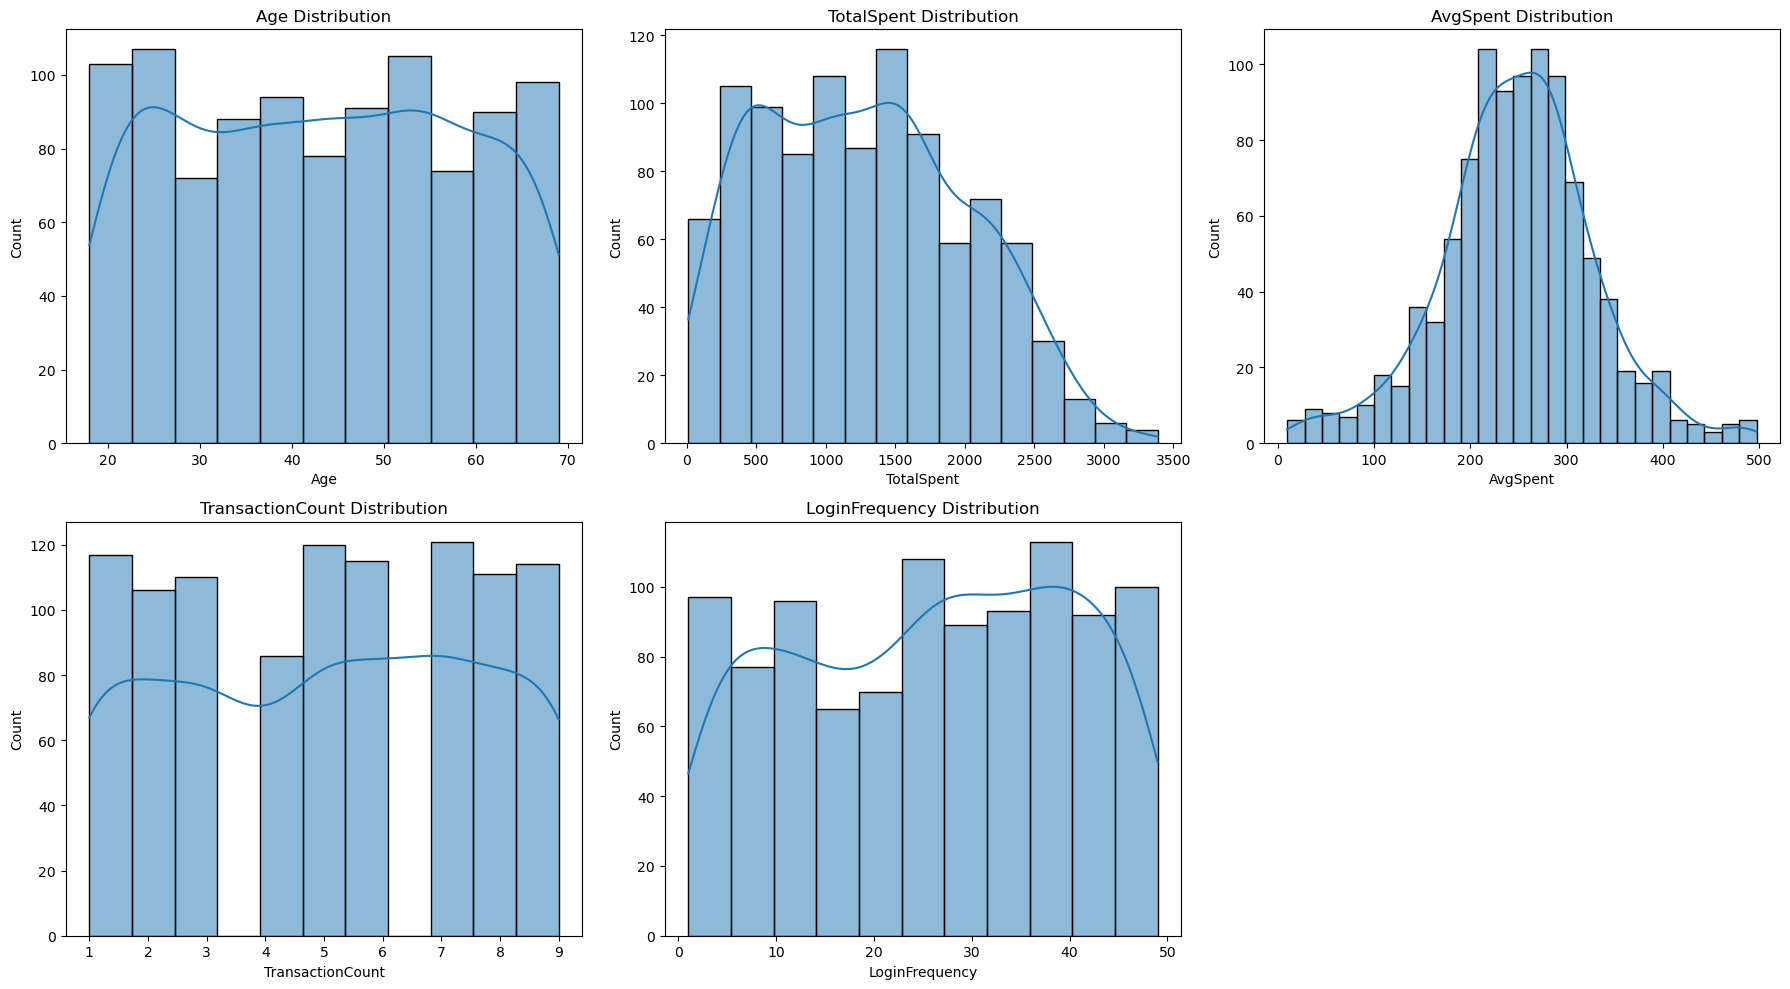

In [127]:
# Visualize distributions of key numerical variables
num_cols = ['Age', 'TotalSpent', 'AvgSpent', 'TransactionCount', 'LoginFrequency']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(num_cols):
    sns.histplot(merged_df[col], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col + ' Distribution')
axes[1,2].axis('off')
plt.tight_layout()
plt.show()

### Age is fairly evenly distributed from 18 to 69, with a slight concentration in the middle age ranges.
### TotalSpent and AvgSpent are right-skewed, meaning most customers spend less, but a few spend much more.
### TransactionCount and LoginFrequency also show right-skewed distributions, with most customers having lower values.

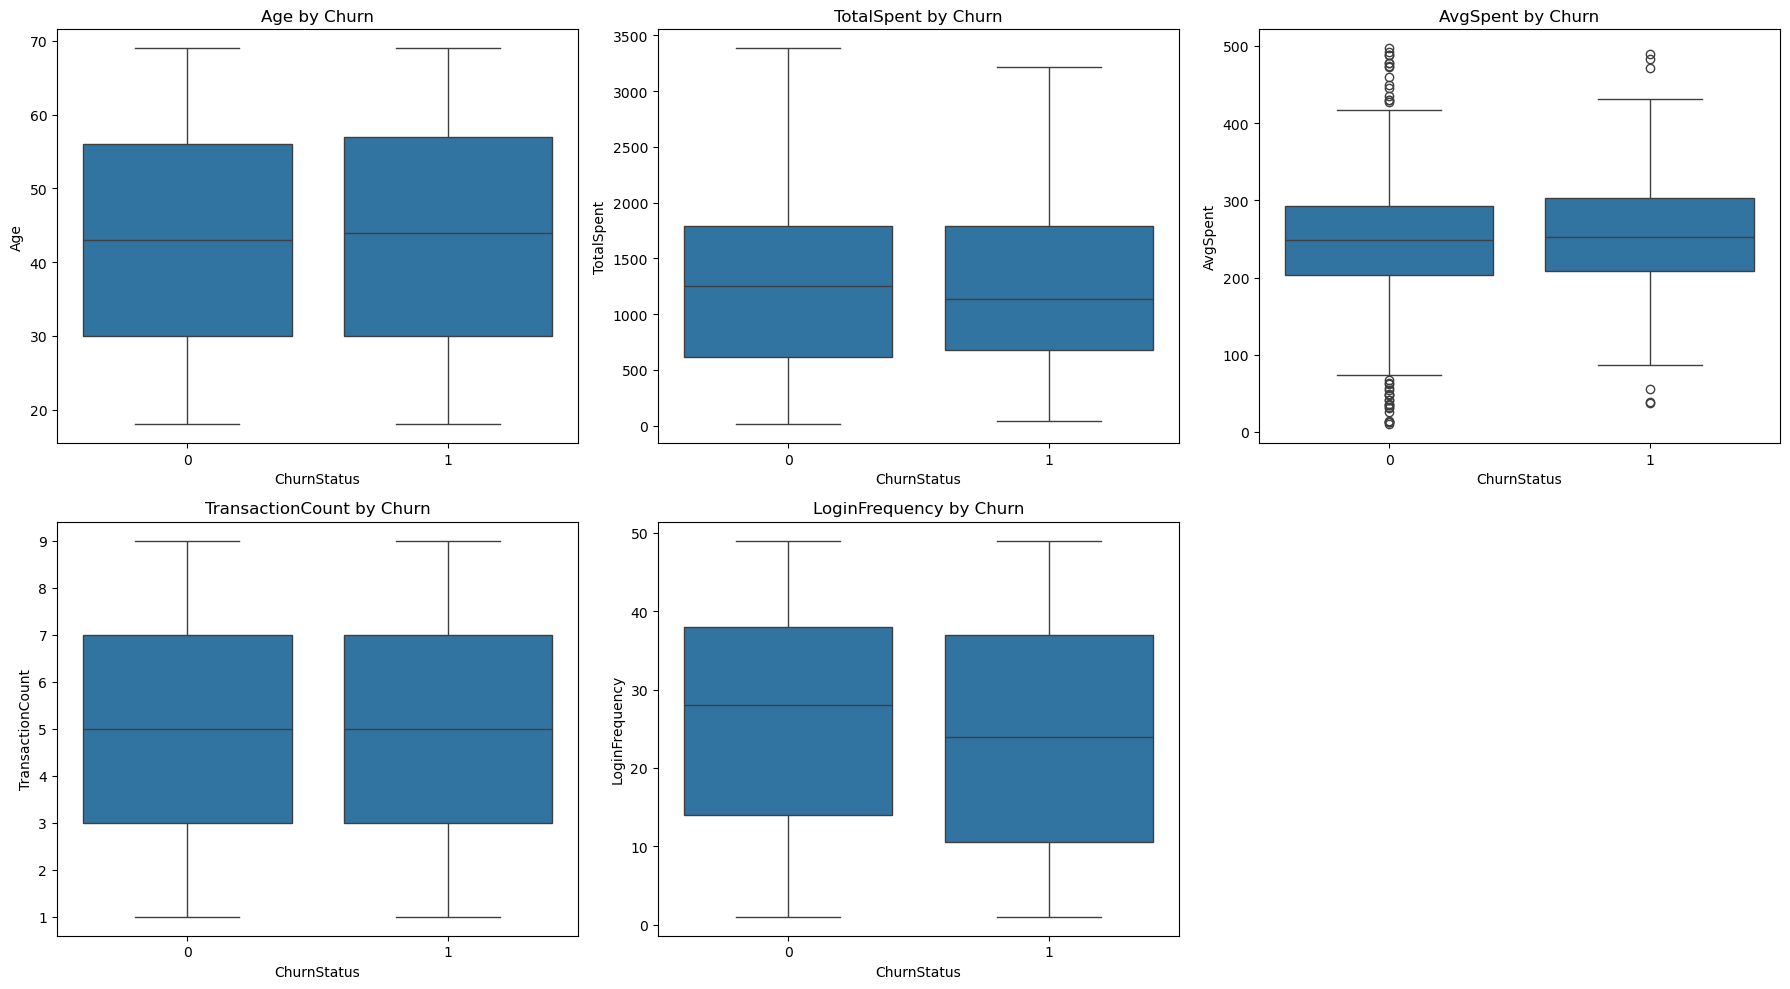

In [128]:
# Boxplots of numerical variables by churn
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(x='ChurnStatus', y=col, data=merged_df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col + ' by Churn')
axes[1,2].axis('off')
plt.tight_layout()
plt.show()

### Customers who churned tend to have lower TotalSpent, AvgSpent, TransactionCount, and LoginFrequency compared to those who stayed.
### Age does not show a strong difference between churned and non-churned customers.

### This suggests that higher engagement and spending are associated with lower churn.

## Corelation matrix

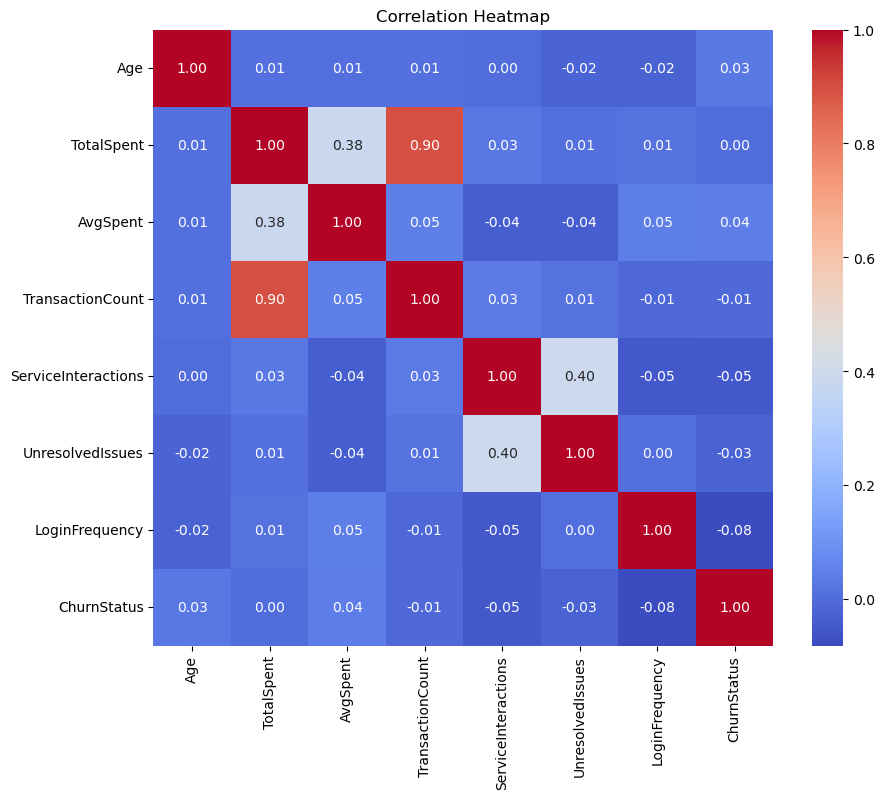

In [129]:
# Correlation heatmap for numerical variables
corr = merged_df[['Age', 'TotalSpent', 'AvgSpent', 'TransactionCount', 'ServiceInteractions', 'UnresolvedIssues', 'LoginFrequency', 'ChurnStatus']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 4. Feature Engineering

### Label Encoding

In [130]:
from sklearn.preprocessing import LabelEncoder
import pickle

# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in categorical_cols:
    label_encoder = LabelEncoder()
    merged_df[column] = label_encoder.fit_transform(merged_df[column])
    encoders[column] = label_encoder

# Save the encoders to a pickle file in the current working directory
with open("/Users/yawdapaa/encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [131]:
encoders

{'Gender': LabelEncoder(),
 'MaritalStatus': LabelEncoder(),
 'IncomeLevel': LabelEncoder(),
 'ServiceUsage': LabelEncoder()}

### Standardise or Normalise Numerical Features

In [132]:
# Drop the target variable 'ChurnStatus' from the numerical features since it had a dtype of int64
numerical_cols = [col for col in numerical_cols if col != "ChurnStatus"]
numerical_cols

['Age',
 'TotalSpent',
 'AvgSpent',
 'TransactionCount',
 'ServiceInteractions',
 'InteractionType',
 'UnresolvedIssues',
 'LoginFrequency']

In [133]:
from sklearn.preprocessing import StandardScaler

# Standardise numerical features
scaler = StandardScaler()
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

# 5. Data Modeling

In [134]:
# Split the data into features (X) and target (y)
x = merged_df.drop(columns=['ChurnStatus'])  # Features
y = merged_df['ChurnStatus']  # Target

In [135]:
from sklearn.model_selection import train_test_split

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [136]:
# Convert continuous target variable to discrete classes
y_train = (y_train > 0).astype(int)
y_test = (y_test > 0).astype(int)

# Check class distribution
print("Class distribution in y_train before SMOTE:")
print(y_train.value_counts())

Class distribution in y_train before SMOTE:
0    646
1    154
Name: ChurnStatus, dtype: int64


#### There is clearly a data imbalance problem, with churned customers being only 20% of the dataset. We will use techniques like SMOTE to balance the dataset.

### Synthetic Minority Over-sampling Technique (SMOTE)

In [137]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Check class distribution after SMOTE
print("Class distribution in y_train after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution in y_train after SMOTE:
0    646
1    646
Name: ChurnStatus, dtype: int64


# 6. Model Traning

There are various machine learning models that can be used for churn prediction, such as Logistic Regression, Decision Trees, Random Forests, Gradient Boosting, and Neural Networks. The choice of model depends on the complexity of the data and the desired interpretability.

In [138]:
# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(max_iter=10000)
}

In [139]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from tqdm import tqdm

# Dictionary to store CV results
cv_results = {}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Stratified K-Fold for imbalanced data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
for model_name, model in tqdm(models.items(), desc="Evaluating Models"):
    print(f"\nTraining {model_name}...")
    
    # Cross-validation with multiple metrics
    scores = cross_validate(
        model, 
        x_train_resampled, 
        y_train_resampled, 
        cv=skf, 
        scoring=scoring,
        return_train_score=False
    )
    
    # Store results
    cv_results[model_name] = {
        'mean_accuracy': np.mean(scores['test_accuracy']),
        'std_accuracy': np.std(scores['test_accuracy']),
        'mean_precision': np.mean(scores['test_precision']),
        'mean_recall': np.mean(scores['test_recall']),
        'mean_f1': np.mean(scores['test_f1']),
        'mean_roc_auc': np.mean(scores['test_roc_auc'])
    }
    
    # Print summary
    print(f"{model_name} CV Results:")
    print(f"Accuracy: {cv_results[model_name]['mean_accuracy']:.2f} ± {cv_results[model_name]['std_accuracy']:.2f}")
    print(f"F1-Score: {cv_results[model_name]['mean_f1']:.2f}")
    print(f"ROC-AUC: {cv_results[model_name]['mean_roc_auc']:.2f}")
    print("-" * 50)

Evaluating Models:   0%|          | 0/8 [00:00<?, ?it/s]


Training Logistic Regression...


Evaluating Models:  12%|█▎        | 1/8 [00:02<00:16,  2.32s/it]

Logistic Regression CV Results:
Accuracy: 0.59 ± 0.02
F1-Score: 0.59
ROC-AUC: 0.65
--------------------------------------------------

Training Decision Tree...
Decision Tree CV Results:
Accuracy: 0.74 ± 0.02
F1-Score: 0.75
ROC-AUC: 0.74
--------------------------------------------------

Training Random Forest...


Evaluating Models:  38%|███▊      | 3/8 [00:03<00:04,  1.07it/s]

Random Forest CV Results:
Accuracy: 0.85 ± 0.02
F1-Score: 0.86
ROC-AUC: 0.92
--------------------------------------------------

Training Gradient Boosting...


Evaluating Models:  75%|███████▌  | 6/8 [00:04<00:00,  2.06it/s]

Gradient Boosting CV Results:
Accuracy: 0.83 ± 0.03
F1-Score: 0.82
ROC-AUC: 0.89
--------------------------------------------------

Training K-Nearest Neighbors...
K-Nearest Neighbors CV Results:
Accuracy: 0.77 ± 0.03
F1-Score: 0.81
ROC-AUC: 0.88
--------------------------------------------------

Training Naive Bayes...
Naive Bayes CV Results:
Accuracy: 0.64 ± 0.03
F1-Score: 0.65
ROC-AUC: 0.69
--------------------------------------------------

Training Support Vector Machine...


Evaluating Models:  88%|████████▊ | 7/8 [00:04<00:00,  1.99it/s]

Support Vector Machine CV Results:
Accuracy: 0.75 ± 0.01
F1-Score: 0.76
ROC-AUC: 0.82
--------------------------------------------------

Training Neural Network...


Evaluating Models: 100%|██████████| 8/8 [00:40<00:00,  5.02s/it]

Neural Network CV Results:
Accuracy: 0.81 ± 0.02
F1-Score: 0.82
ROC-AUC: 0.88
--------------------------------------------------


## Model Performance Conclusion
The cross-validation results reveal clear differences in performance across the eight models tested. Here’s a breakdown of key findings and recommendations:

### Top Performers (High Accuracy + Robustness)
**Random Forest**

Best overall: Highest accuracy (0.85 ± 0.02) and F1-score (0.86).

Strong AUC (0.92): Excellent at distinguishing classes (ideal for imbalanced data).

Low variance (±0.02): Consistent across folds.

**Gradient Boosting & Neural Network**

Close contenders: Accuracy ~0.82–0.83 and AUC ~0.88–0.89.

Trade-off: Gradient Boosting trains faster, while Neural Networks may need hyperparameter tuning for stability.

### Moderate Performers
K-Nearest Neighbors (KNN) & SVM

Decent accuracy (0.75–0.77), but lower than ensemble methods.

KNN’s high F1 (0.81): Good for balanced precision/recall.

SVM’s AUC (0.82): Reasonable but computationally expensive.

Decision Tree

Overfitting risk: Simpler than Random Forest (accuracy 0.74), but useful for interpretability.

### Weak Performers
Logistic Regression & Naive Bayes

Low accuracy (0.59–0.64): Likely due to non-linear data patterns.

Naive Bayes’ poor AUC (0.69): Assumes feature independence, which may not hold here.

# 7. Model Evalustion with Random Forest Classifier
## Train the Random Forest model

In [140]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [141]:
print(y_test.value_counts())

0    150
1     50
Name: ChurnStatus, dtype: int64


In [142]:
x_test_resampled, y_test_resampled = smote.fit_resample(x_test, y_test)

In [143]:
# Evaluate the model on the test set
y_pred = rf.predict(x_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2f}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.71
Precision Score: 0.36
Recall Score: 0.18
Confusion Matrix:
 [[134  16]
 [ 41   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       150
           1       0.36      0.18      0.24        50

    accuracy                           0.71       200
   macro avg       0.56      0.54      0.53       200
weighted avg       0.66      0.71      0.68       200



### Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

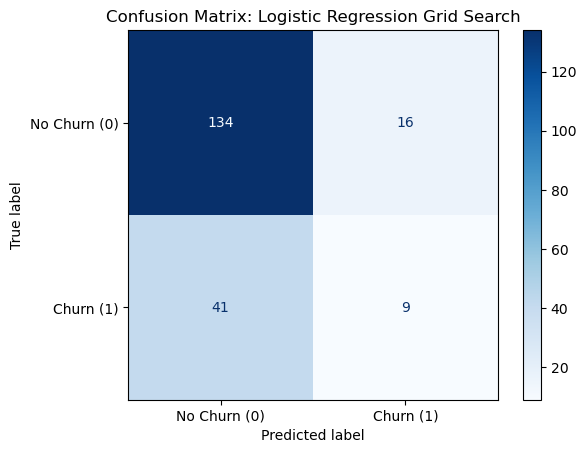

In [144]:
display_logit_grid = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['No Churn (0)', 'Churn (1)'])

plt.figure(figsize=(10,10))

display_logit_grid.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix: Logistic Regression Grid Search')
plt.show()

# 8. Saving Pickle file

In [145]:
# Save model and feature names as a dictionary
model_data= {"model": rf, "features_names": x.columns.tolist()}

# Save to file
with open("/Users/yawdapaa/customer_churn_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

In [146]:
print(model_data["model"])
print(model_data["features_names"])

RandomForestClassifier(random_state=42)
['Age', 'Gender', 'MaritalStatus', 'IncomeLevel', 'TotalSpent', 'AvgSpent', 'TransactionCount', 'ServiceInteractions', 'InteractionType', 'UnresolvedIssues', 'LoginFrequency', 'ServiceUsage']


# 9. Load the Model and Predict with New Data

In [147]:
# load the saved model and features
with open("/Users/yawdapaa/customer_churn_model.pkl", "rb") as f:
    model_data = pickle.load(f)

loaded_model = model_data["model"]
features_names = model_data["features_names"]

In [152]:
input_data = {
    "Age": 42,
    "Gender": "M",
    "MaritalStatus": "Divorced",
    "IncomeLevel": "High",
    "TotalSpent": 7800.00,
    "AvgSpent": 5200.75,
    "TransactionCount": 95,
    "LastTransactionDate": "9/10/23",
    "ServiceInteractions": 5,
    "InteractionType": 3,
    "UnresolvedIssues": 2,
    "LastLoginDate": "10/5/23",
    "LoginFrequency": 20,
    "ServiceUsage": "Website"
}

In [153]:
# Filter input_data to only include keys present in feature_names
filtered_input_data = {key: value for key, value in input_data.items() if key in features_names}

# Convert to DataFrame
input_df = pd.DataFrame([filtered_input_data])
input_df

,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,TransactionCount,ServiceInteractions,InteractionType,UnresolvedIssues,LoginFrequency,ServiceUsage
0,42,M,Divorced,High,7800.0,5200.75,95,5,3,2,20,Website


In [155]:
# Load encoders
with open("/Users/yawdapaa/encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

# Apply label encoding or other transformations
for column in encoders.keys():
    if column in input_df.columns:
        input_df[column] = encoders[column].transform(input_df[column])
    else:
        # Optionally log or warn
        print(f"Warning: {column} not in input data — skipping transformation.")

In [156]:
# Predict
prediction = loaded_model.predict(input_df[features_names])
prediction_proba = loaded_model.predict_proba(input_df[features_names])


# results
print("Prediction:", prediction)
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'Not Churn'}")
print(f"Probability of Churn: {prediction_proba}")

Prediction: [0]
Prediction: Not Churn
Probability of Churn: [[0.56 0.44]]
